# Exercise Sheet 4 - Lucas Oswald, Maximilian Stucke, Milon Miah

In [1]:
import numpy as np
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import lsqr
import matplotlib.pyplot as plt

In [2]:
#Read in data
alphas_77 = np.load('hs_tomography/alphas_77.npy')
y_77 = np.load('hs_tomography/y_77.npy')
alphas_195 = np.load('hs_tomography/alphas_195.npy')
y_195 = np.load('hs_tomography/y_195.npy')


## 1. Constructing X

In [14]:
#Function for constructing X
def construct_X(M, alphas, Np = None):
    
    #Adapt N_p to diagonal of image in case of no given value
    if Np == None:
        Np = int(np.sqrt(2)*M + 1)
    
    #Define function for using i = i_p + N_p*i_o, this function creates an array to be added to 2D index array 
    def index_N(i, j):
        return (i * Np)

    #Create array holding the coordinates of the tomogram's pixel centers
    a0 = -M/2+0.5
    b0 = -M/2+0.5
    j_b, j_a = np.mgrid[a0:M/2, b0:M/2]
    j_b = j_b * (-1)
    C = np.array([j_a, j_b])
    C = C.reshape(2, M**2)
    
    #Compute unit vector along rotating sensor for array of angles
    n_a = np.cos(alphas*2*np.pi/360)
    n_b = np.sin(alphas*2*np.pi/360)
    n = np.array([n_a, n_b])
    
    #Calculate projection of each pixel onto the sensor
    s0 = (Np-1)/2
    p = np.dot(n.T, C) + s0    
    
    #Prepare sparse matrix with weights and their indices 
    
    #Define dimensions of sparse matrix
    No = alphas.size
    N = Np * No
    D = M**2
    
    #Derive weights from decimal part of projection -> % helps here 
    weights = np.concatenate((1 - (p % 1), p % 1)).flatten()
    
    #Derive two participating sensor elements -> Use function from above to write i indices in i = i_p+N_p*i_o
    pos = p.astype(int)
    index_correction = np.fromfunction(index_N, pos.shape)
    pos = (pos + index_correction)
    
    i_indices = np.concatenate((pos, pos + 1)).flatten()
    j_indices = np.tile(np.arange(0, D, 1), 2*No)
    
    #Finally compute sparse matrix
    X = coo_matrix((weights, (i_indices, j_indices)), shape = (N, D), dtype = np.float32)
    return X

[[ 4.5  4.5  4.5  4.5  4.5  4.5  4.5  4.5  4.5  4.5]
 [ 3.5  3.5  3.5  3.5  3.5  3.5  3.5  3.5  3.5  3.5]
 [ 2.5  2.5  2.5  2.5  2.5  2.5  2.5  2.5  2.5  2.5]
 [ 1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5]
 [ 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5]
 [-0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5]
 [-1.5 -1.5 -1.5 -1.5 -1.5 -1.5 -1.5 -1.5 -1.5 -1.5]
 [-2.5 -2.5 -2.5 -2.5 -2.5 -2.5 -2.5 -2.5 -2.5 -2.5]
 [-3.5 -3.5 -3.5 -3.5 -3.5 -3.5 -3.5 -3.5 -3.5 -3.5]
 [-4.5 -4.5 -4.5 -4.5 -4.5 -4.5 -4.5 -4.5 -4.5 -4.5]]
[[-4.5 -3.5 -2.5 -1.5 -0.5  0.5  1.5  2.5  3.5  4.5]
 [-4.5 -3.5 -2.5 -1.5 -0.5  0.5  1.5  2.5  3.5  4.5]
 [-4.5 -3.5 -2.5 -1.5 -0.5  0.5  1.5  2.5  3.5  4.5]
 [-4.5 -3.5 -2.5 -1.5 -0.5  0.5  1.5  2.5  3.5  4.5]
 [-4.5 -3.5 -2.5 -1.5 -0.5  0.5  1.5  2.5  3.5  4.5]
 [-4.5 -3.5 -2.5 -1.5 -0.5  0.5  1.5  2.5  3.5  4.5]
 [-4.5 -3.5 -2.5 -1.5 -0.5  0.5  1.5  2.5  3.5  4.5]
 [-4.5 -3.5 -2.5 -1.5 -0.5  0.5  1.5  2.5  3.5  4.5]
 [-4.5 -3.5 -2.5 -1.5 -0.5  0.5  1.5  2.5  3.

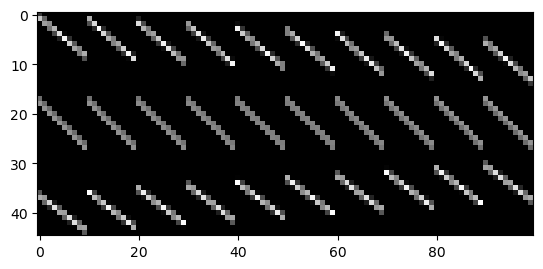

In [12]:
#Compare image with result on sheet
X = construct_X(10, np.array([-33, 1, 42]), Np = 15).todense()
plt.figure()
plt.imshow(X, cmap = 'gray')

### This is just the same matrix as the matrix provided in the exercise sheet.

## 2. Recovering the Image

### First try reconstructing the image with the M = 77 dataset

In [20]:
#Construct X with M = 77, Np = 109 and given alphas
M = 77
Np = 109
X_77 = construct_X(M, alphas_77, Np = Np)

#Compute sparsity
sparsity = 1.0 - (X_77.nnz / (X_77.shape[0] * X_77.shape[1]))
print('The sparsity is given by {:.2f} and there are {} non-zero entries.'.format(sparsity, X_77.nnz))

#Use least square solver from scipy to obtain beta
beta_77 = lsqr(X_77, y_77, atol = 1e-08, btol = 1e-08)[0]


The sparsity is given by 0.98 and there are 1067220 non-zero entries.


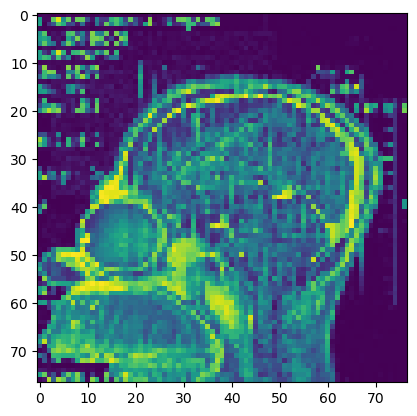

In [21]:
beta_77 = beta_77.reshape(M, M)

#Plot recovered image
plt.figure()
plt.imshow(beta_77)

### Using the M = 195 dataset gives much higher resolved images

In [22]:
#Construct X with M = 195, Np = 275 and given alphas
M = 195
Np = 275
X_195 = construct_X(M, alphas_195, Np = Np)

#Compute sparsity
sparsity = 1.0 - (X_195.nnz / (X_195.shape[0] * X_195.shape[1]))
print('The sparsity is given by {:.2f} and there are {} non-zero entries.'.format(sparsity, X_195.nnz))

#Use least square solver from scipy to obtain beta
beta_195 = lsqr(X_195, y_195, atol = 1e-05, btol = 1e-05)[0]


The sparsity is given by 0.99 and there are 13612950 non-zero entries.


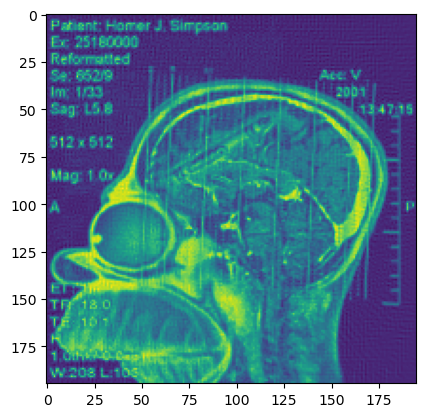

In [23]:
beta_195 = beta_195.reshape(M, M)

#Plot recovered image
plt.figure()
plt.imshow(beta_195)

### There is an object caught in H.S. brain. There is no other way than undergoing a risky surgery.  

# Minimizing the radiation dose

In [28]:
#Remove some of the angles
M = 195
Np = 275
No = len(alphas_195)

alphas_195_red = alphas_195[::10]
s_195 = y_195.reshape(No, Np)
s_195_red = s_195[::10, :]
y_195_red = s_195_red.flatten()
X_195_red = construct_X(M, alphas_195_red, Np = Np)

#Compute sparsity
sparsity = 1.0 - (X_195_red.nnz / (X_195_red.shape[0] * X_195_red.shape[1]))
print('The sparsity is given by {:.2f} and there are {} non-zero entries.'.format(sparsity, X_195_red.nnz))

#Use least square solver from scipy to obtain beta
beta_red = lsqr(X_195_red, y_195_red, atol = 1e-05, btol = 1e-05)[0]


The sparsity is given by 0.99 and there are 1368900 non-zero entries.


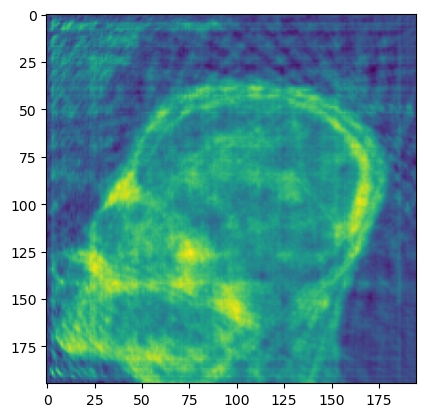

In [30]:
beta_red = beta_red.reshape(M, M)

#Plot recovered image
plt.figure()
plt.imshow(beta_red)

### Only after having removed 9 out of 10 angles (drop 90 %), the object in H.S. head is barely visible anymore. Thus, the radiation dose can be reduced significantly!